In [1]:
import xarray
import dask
import numpy
import itertools
import scipy.optimize
from dask.diagnostics import ProgressBar
import climtas.nci

In [2]:
climtas.nci.GadiClient()

Client Scheduler: tcp://127.0.0.1:44155 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 1 Memory: 4.29 GB


In [18]:
cable_hist = xarray.open_mfdataset('/g/data/p66/txz599/data/luc_hist_maps/cableCMIP6_LC_*.nc', combine='nested', concat_dim='time').load()
cable_hist.coords['vegtype'] = [ 'Evergreen Needleleaf Forest', 'Evergreen Broadleaf Forest ', 'Deciduous Needleleaf Forest', 'DeciduousBroadleafForest', 'shrub', 'C3grass', 'C4grass', 'tundra', 'C3crop', 'C4crop', 'wetland', 'notused1', 'notused2', 'barren', 'urban', 'lakes', 'ice' ]

In [19]:
luh_hist = xarray.open_dataset('/g/data/w35/saw562/access-esm/luh2_v2h_states_N96.nc', decode_times=False, chunks={'lat': 10, 'lon': 10})
luh_hist.coords['time'] = luh_hist.coords['time'] + 850

In [20]:
luh_types = ['c3ann','c3nfx','c3per','c4ann','c4per','pastr','primf','primn','range','secdf','secdn','urban']
luh_hist_da = xarray.concat([*[luh_hist[t] for t in luh_types], luh_hist['urban'].fillna(0) * 0 + 1], dim='type')
luh_hist_da.coords['type'] = [*luh_types, 'constant']

In [21]:
def estimate_block(cable, luh2):
    nx = cable.shape[2]
    ny = cable.shape[3]
    ntc = cable.shape[1]
    ntl = luh2.shape[0]
    
    weights = numpy.full((ntl, ntc, nx, ny), numpy.nan, dtype='f')
    estimate = {}
    
    # For each grid point
    for i,j in itertools.product(range(nx),range(ny)):
        #print(i,j)
        
        if numpy.isnan(cable[0,0,i,j]):
            # Masked cable point
            continue
        
        # luh2 values at this grid point
        source = luh2[:,:,i,j]
        
        if numpy.isnan(source[0,0]):
            # Masked luh2 point, set to a constant
            weights[:, :, i, j] = [[0]*ntc]*ntl
            weights[-1,:, i, j] = cable[:,:,i,j].mean(axis=0)
            continue
            
        # If values for a type are all zero, that type doesn't contribute
        mask = numpy.all(source == 0, axis=1)
        bounds = [(0, 0.1) if m else (-5, 5) for m in mask]
        
        # For each cable type
        for t in range(ntc):
            if t in [11, 12, 14, 15, 16]:
                weights[:, t, i, j] = 0
            
            measure = cable[:,t,i,j]
            
            if numpy.all(measure == 0):
                # No CABLE data to match against
                weights[:, t, i, j] = 0
                continue
                
            def opt(x):
                # Optimise RMSE
                estimate = (source * x[:, None]).sum(axis=0)
                rmse = numpy.sqrt(((estimate[-measure.size:] - measure)**2).mean())
                
                estmin = numpy.min(estimate)
                if estmin < 0:
                    rmse += -estmin
                    
                estmax = numpy.max(estimate)
                if estmax > 1:
                    rmse += (estmax-1)
                    
                return rmse
            
            r = scipy.optimize.minimize(opt, estimate.get(t, [0.2]*13), bounds=bounds)

            weights[:, t, i, j] = r.x
            
            # Store the weights as the next solver starting point for this type
            estimate[t] = weights[:, t, i, j]

    return weights

In [22]:
cable = cable_hist.fraction.chunk({'latitude': 10, 'longitude': 10}).data
luh2 = luh_hist_da.chunk({'lat': 10, 'lon': 10}).data

In [10]:
with ProgressBar():
    cable[:,:,:5,:5].compute()

In [38]:
estimate_block(cable[:,:,:2,:2], luh2[:,:,:2,:2]);

0 0
0 1
1 0
1 1


In [11]:
data = dask.array.map_blocks(estimate_block, cable, luh2, dtype='f', drop_axis=0, new_axis=0, chunks=(luh2.shape[0], cable.chunks[1], cable.chunks[2], cable.chunks[3]))

In [12]:
data

,Array,Chunk
Bytes,24.61 MB,88.40 kB
Shape,"(13, 17, 145, 192)","(13, 17, 10, 10)"
Count,13512 Tasks,300 Chunks
Type,float32,numpy.ndarray


In [13]:
luh_weights = xarray.DataArray(
                 data,
                 name='luh2_to_cable_types',
                 coords=[
                     ('luh2_type', luh_hist_da['type']),
                     ('cable_type', cable_hist['vegtype']), 
                     ('lat', cable_hist['latitude']), 
                     ('lon', cable_hist['longitude']), 
                 ])
luh_weights

,Array,Chunk
Bytes,24.61 MB,88.40 kB
Shape,"(13, 17, 145, 192)","(13, 17, 10, 10)"
Count,13512 Tasks,300 Chunks
Type,float32,numpy.ndarray


In [14]:
with ProgressBar():
    luh_weights.to_netcdf('luh2_to_cable_types_v2.nc')

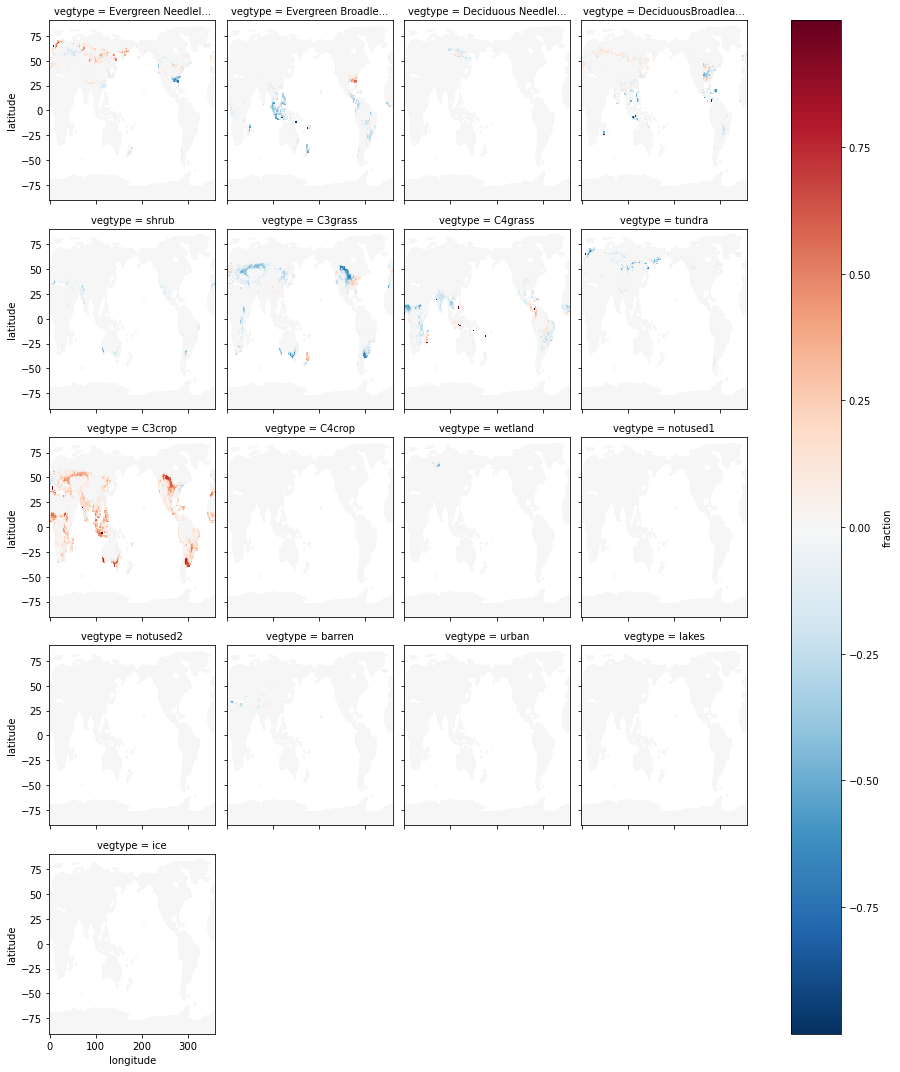

In [15]:
delta = cable_hist.fraction[-1,...] - cable_hist.fraction[0,...]
delta.plot(col='vegtype', col_wrap=4)

In [66]:
luh_weights = xarray.open_dataarray('luh2_to_cable_types_v2.nc')

In [17]:
rebuilt_hist = (luh_weights * luh_hist_da.rename(type='luh2_type').fillna(0).chunk({'time': 50})).sum('luh2_type').transpose('time', 'cable_type', 'lat', 'lon')
#rebuilt_hist = rebuilt_hist / rebuilt_hist.sum('cable_type')
rebuilt_hist.name = 'cable_fraction'
rebuilt_hist

,Array,Chunk
Bytes,2.21 GB,340.00 kB
Shape,"(1166, 17, 145, 192)","(50, 17, 10, 10)"
Count,824413 Tasks,7200 Chunks
Type,float32,numpy.ndarray


In [18]:
rebuilt_hist.to_netcdf('luh2_v2h_states_cable_N96_v2.nc')

In [63]:
rebuilt_hist = xarray.open_dataarray('luh2_v2h_states_cable_N96_v2.nc', chunks={'time': 10})

In [4]:
rebuilt_hist

,Array,Chunk
Bytes,2.21 GB,18.93 MB
Shape,"(1166, 17, 145, 192)","(10, 17, 145, 192)"
Count,118 Tasks,117 Chunks
Type,float32,numpy.ndarray


In [5]:
rebuilt_hist_norm = rebuilt_hist / rebuilt_hist.sum('cable_type')
rebuilt_hist_norm

,Array,Chunk
Bytes,2.21 GB,18.93 MB
Shape,"(1166, 17, 145, 192)","(10, 17, 145, 192)"
Count,937 Tasks,117 Chunks
Type,float32,numpy.ndarray


In [6]:
rebuilt_hist_norm.to_netcdf('luh2_v2h_states_cable_N96_v2_norm.nc')

In [2]:
rebuilt_hist_norm = xarray.open_dataarray('luh2_v2h_states_cable_N96_v2_norm.nc', chunks={'time': 10})

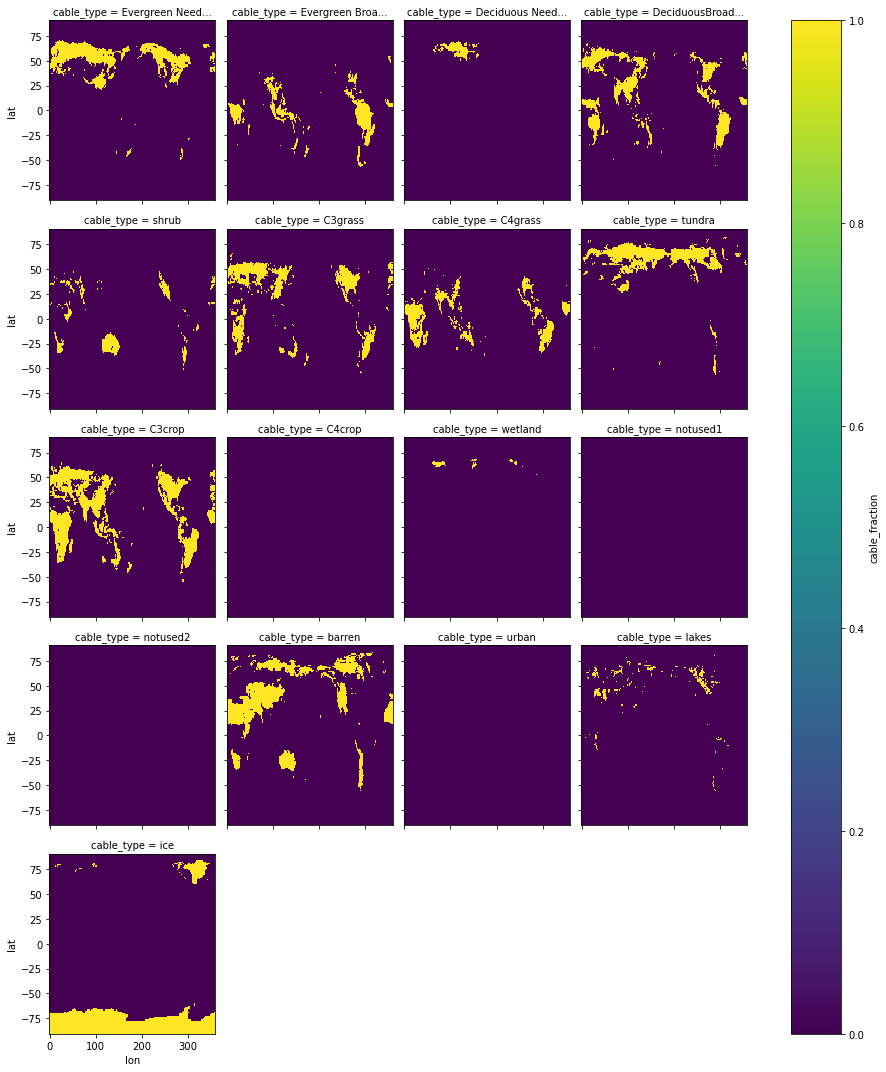

In [3]:
active_tiles = (rebuilt_hist_norm.sum('time') > 0).load()

active_tiles.plot(col='cable_type', col_wrap=4)

In [4]:
rebuilt_hist_floor = rebuilt_hist_norm + xarray.where(active_tiles, 1e-6, 0)
rebuilt_hist_floor

,Array,Chunk
Bytes,4.41 GB,37.86 MB
Shape,"(1166, 17, 145, 192)","(10, 17, 145, 192)"
Count,236 Tasks,117 Chunks
Type,float64,numpy.ndarray


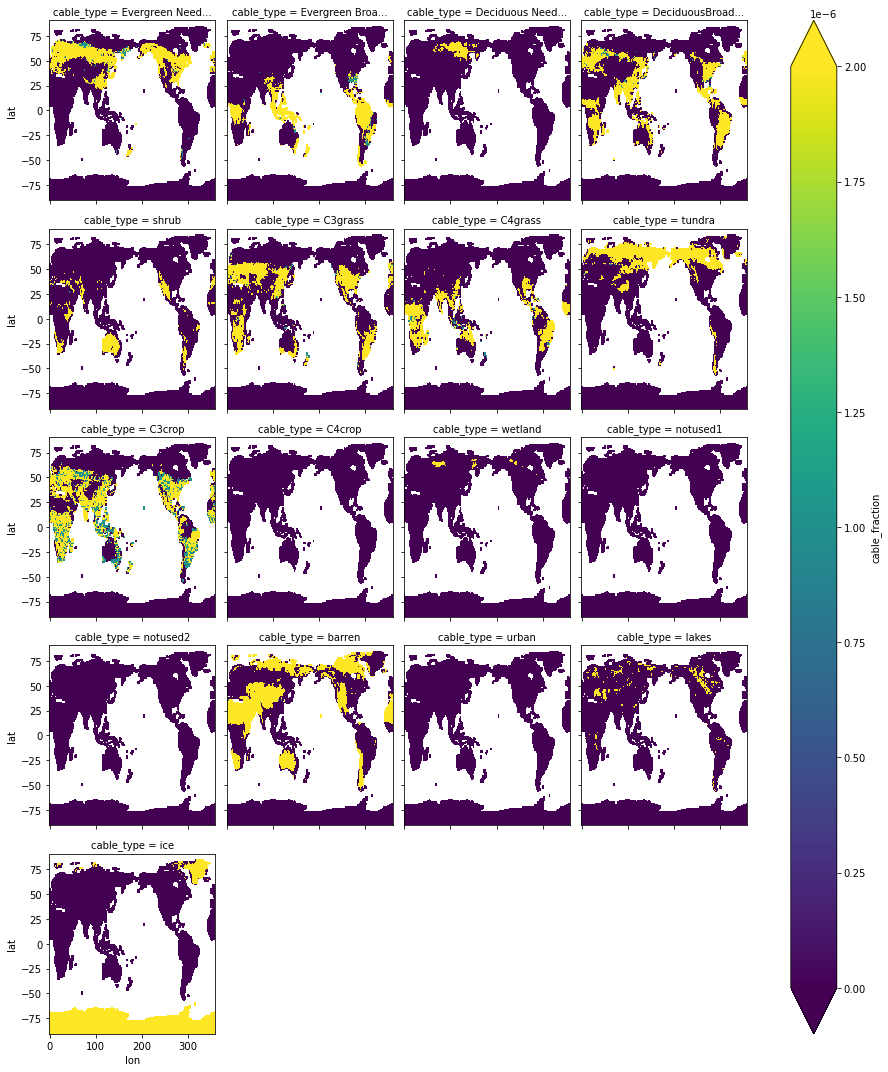

In [5]:
rebuilt_hist_floor[0,...].plot(col='cable_type', col_wrap=4, vmin=0, vmax=2e-6)

In [7]:
rebuilt_hist_floor.to_netcdf('luh2_v2h_states_cable_N96_v3.nc')

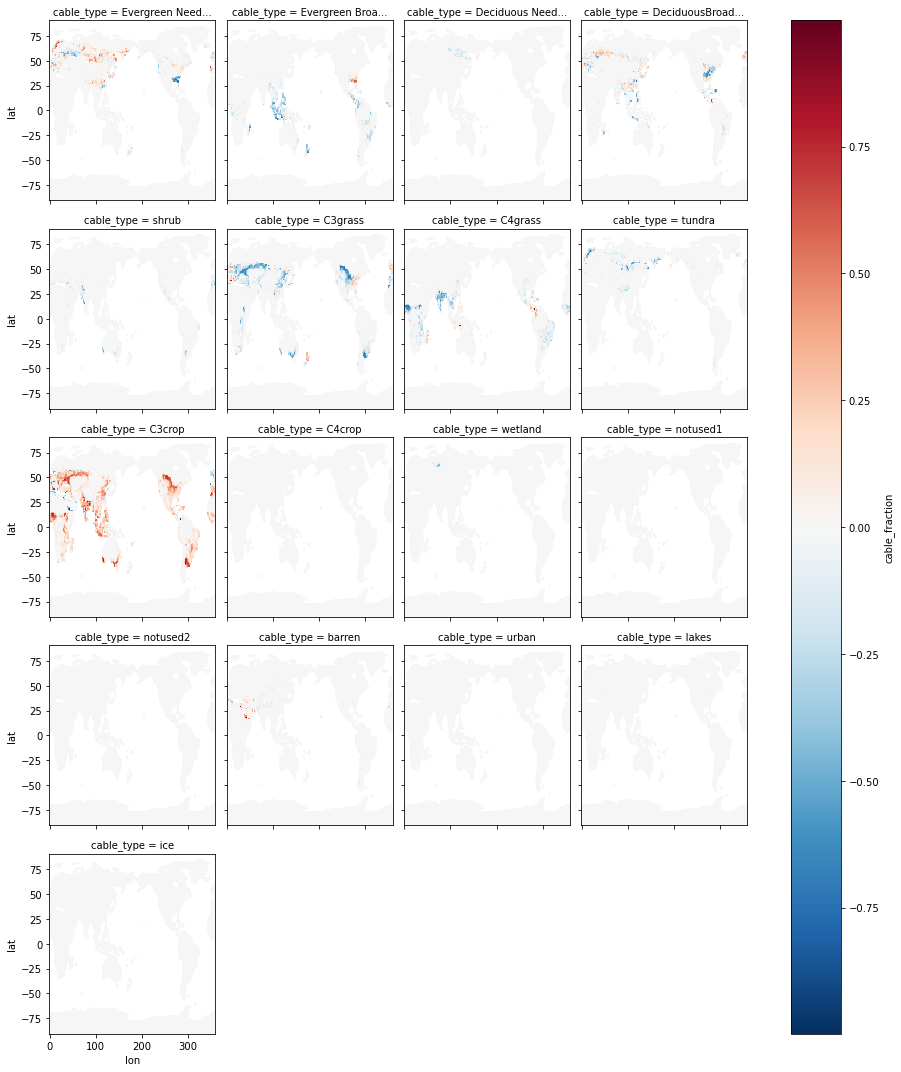

In [38]:
delta = rebuilt_hist[-1,...]/(rebuilt_hist[-1,...].sum('cable_type')) - rebuilt_hist[0,...]/(rebuilt_hist[0,...].sum('cable_type'))
delta.plot(col='cable_type', col_wrap=4)

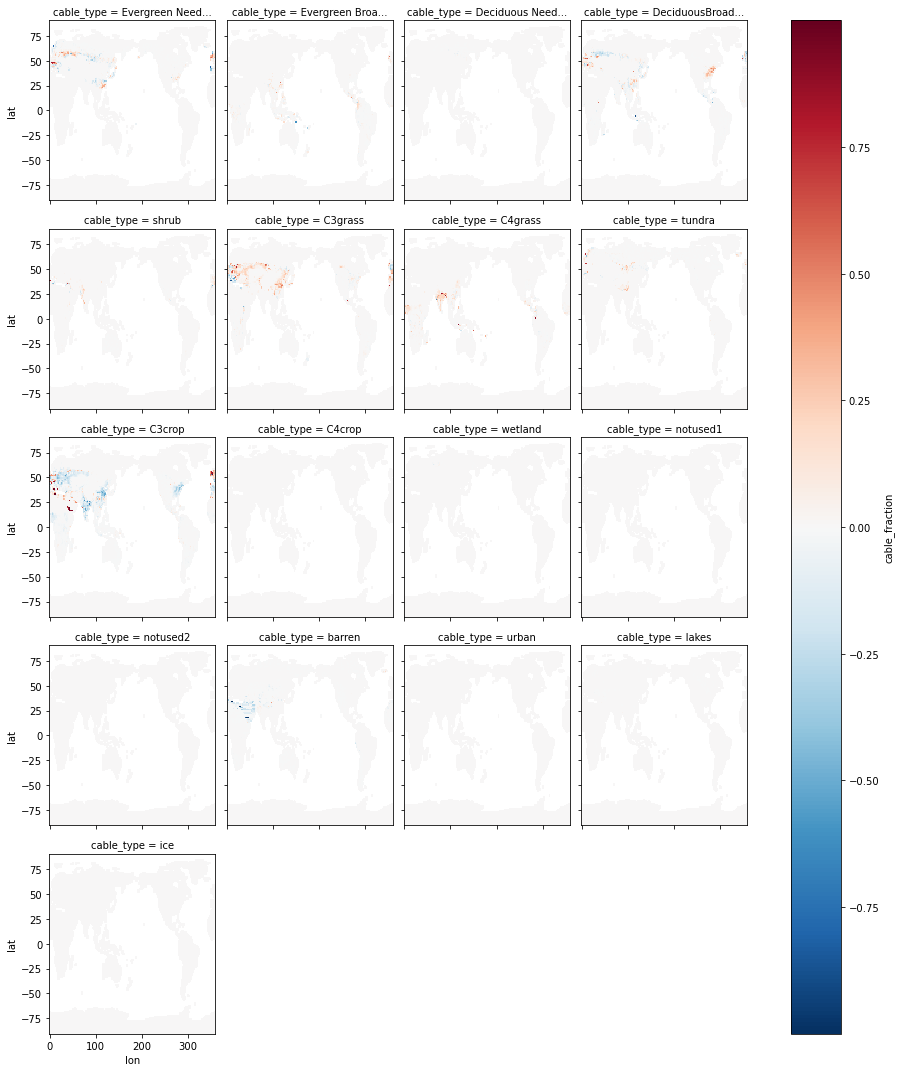

In [24]:
delta = rebuilt_hist[0,...] - cable_hist.fraction[0,...].data
delta.plot(col='cable_type', col_wrap=4)

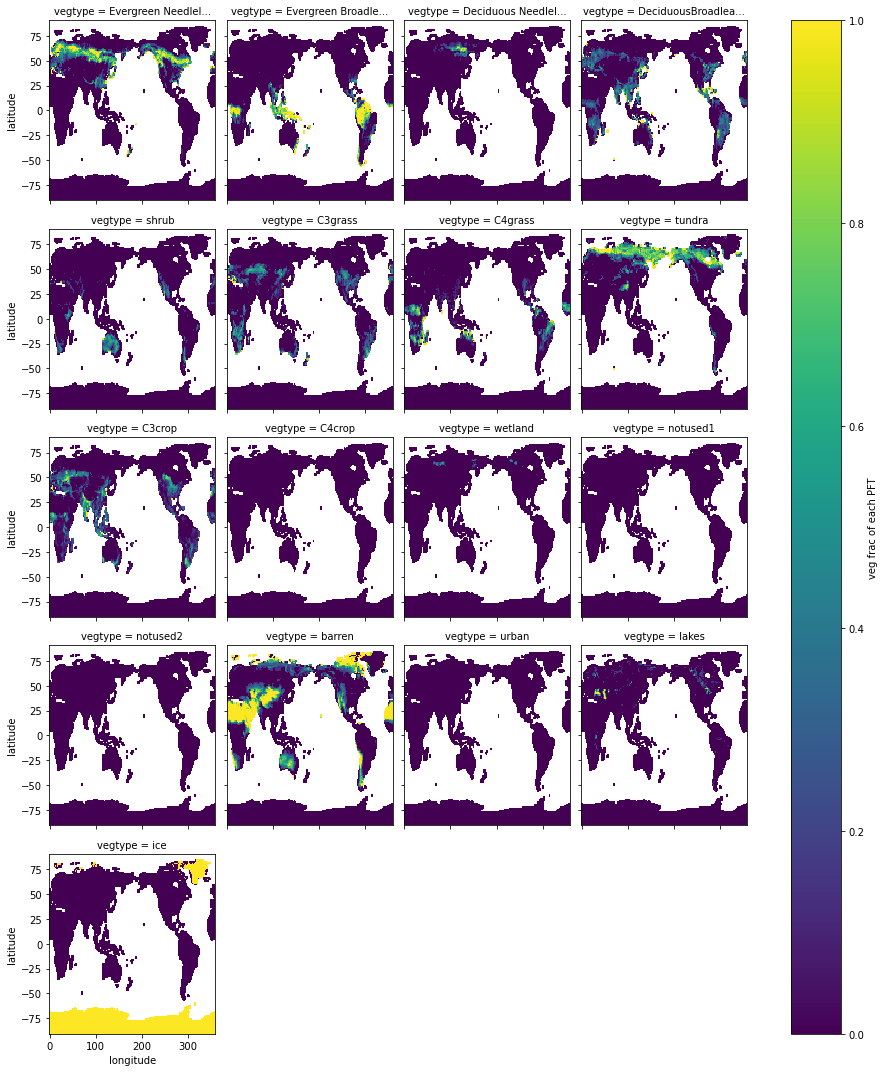

In [37]:
cable_hist.fraction[-1,...].plot(col='vegtype', col_wrap=4)

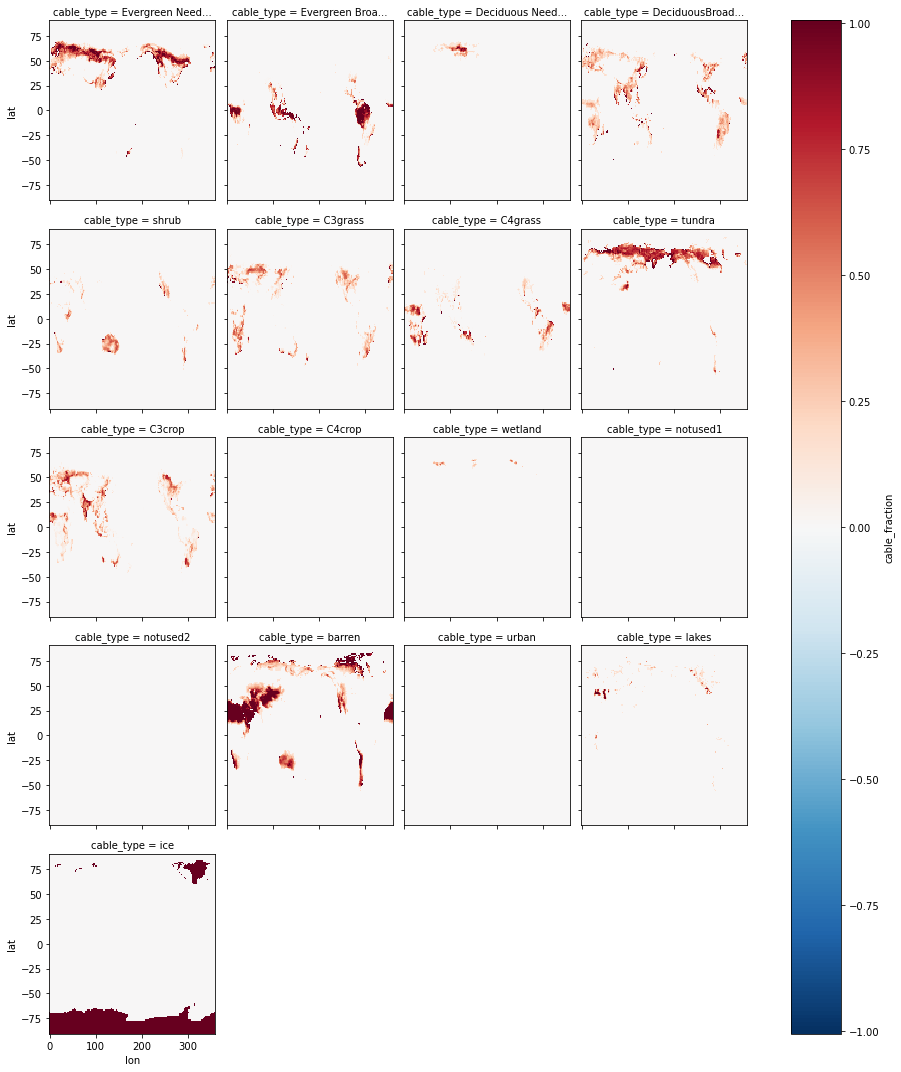

In [32]:
rebuilt_hist[-1,...].plot(col='cable_type', col_wrap=4)

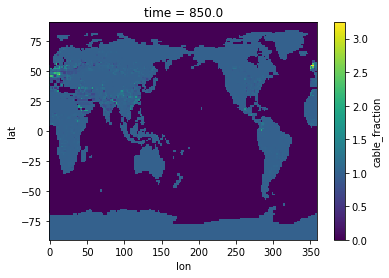

In [29]:
rebuilt_hist[0,...].sum('cable_type').plot()

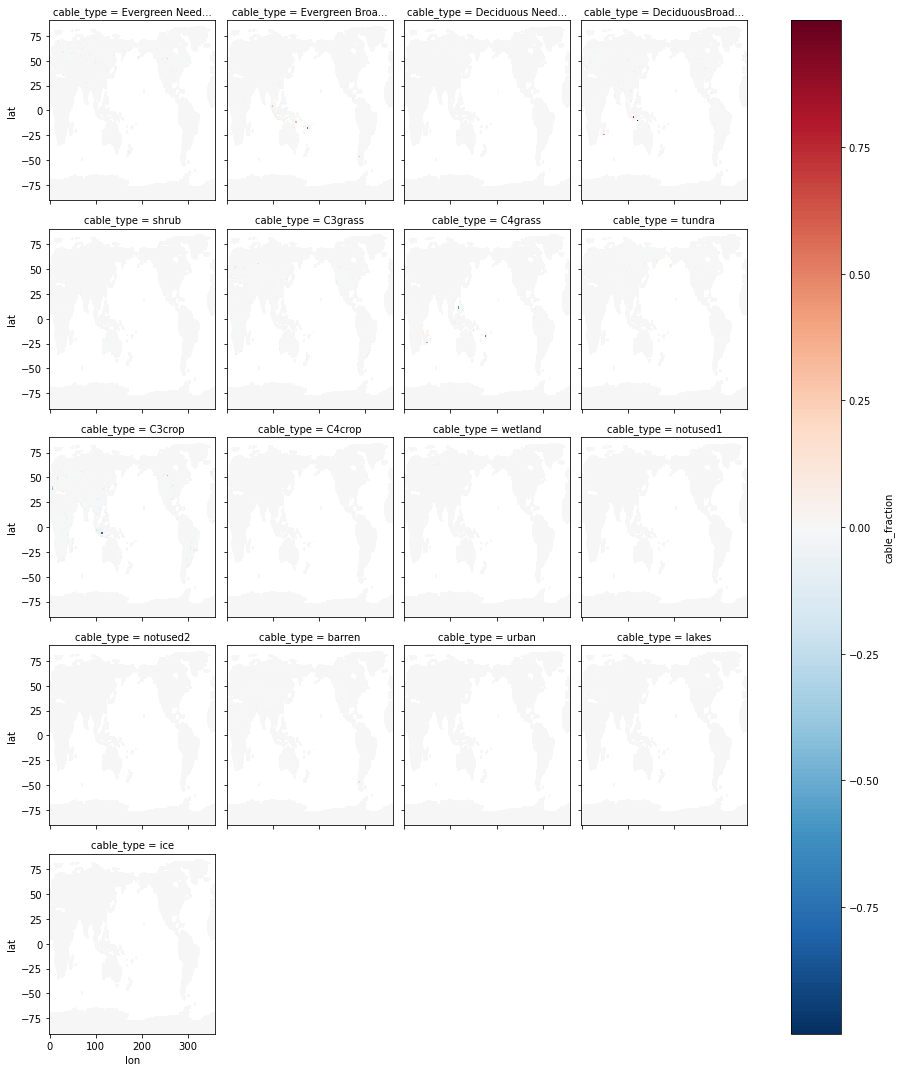

In [36]:
delta = rebuilt_hist[-1,...]/(rebuilt_hist[-1,...].sum('cable_type')) - cable_hist.fraction[-1,...].data
delta.plot(col='cable_type', col_wrap=4)

In [34]:
rebuilt_hist.time

<xarray.DataArray 'time' (time: 1166)>
array([ 850.,  851.,  852., ..., 2013., 2014., 2015.])
Coordinates:
  * time     (time) float64 850.0 851.0 852.0 ... 2.013e+03 2.014e+03 2.015e+03

In [35]:
cable_hist.time

<xarray.DataArray 'time' (time: 166)>
array(['1851-01-01T00:00:00.000000000', '1852-01-01T00:00:00.000000000',
       '1853-01-01T00:00:00.000000000', '1854-01-01T00:00:00.000000000',
       '1855-01-01T00:00:00.000000000', '1856-01-01T00:00:00.000000000',
       '1857-01-01T00:00:00.000000000', '1858-01-01T00:00:00.000000000',
       '1859-01-01T00:00:00.000000000', '1860-01-01T00:00:00.000000000',
       '1861-01-01T00:00:00.000000000', '1862-01-01T00:00:00.000000000',
       '1863-01-01T00:00:00.000000000', '1864-01-01T00:00:00.000000000',
       '1865-01-01T00:00:00.000000000', '1866-01-01T00:00:00.000000000',
       '1867-01-01T00:00:00.000000000', '1868-01-01T00:00:00.000000000',
       '1869-01-01T00:00:00.000000000', '1870-01-01T00:00:00.000000000',
       '1871-01-01T00:00:00.000000000', '1872-01-01T00:00:00.000000000',
       '1873-01-01T00:00:00.000000000', '1874-01-01T00:00:00.000000000',
       '1875-01-01T00:00:00.000000000', '1876-01-01T00:00:00.000000000',
       '1877-01-01T00:00:00.000000000', '1878-01-01T00:00:00.000000000',
       '1879-01-01T00:00:00.000000000', '1880-01-01T00:00:00.000000000',
       '1881-01-01T00:00:00.000000000', '1882-01-01T00:00:00.000000000',
       '1883-01-01T00:00:00.000000000', '1884-01-01T00:00:00.000000000',
       '1885-01-01T00:00:00.000000000', '1886-01-01T00:00:00.000000000',
       '1887-01-01T00:00:00.000000000', '1888-01-01T00:00:00.000000000',
       '1889-01-01T00:00:00.000000000', '1890-01-01T00:00:00.000000000',
       '1891-01-01T00:00:00.000000000', '1892-01-01T00:00:00.000000000',
       '1893-01-01T00:00:00.000000000', '1894-01-01T00:00:00.000000000',
       '1895-01-01T00:00:00.000000000', '1896-01-01T00:00:00.000000000',
       '1897-01-01T00:00:00.000000000', '1898-01-01T00:00:00.000000000',
       '1899-01-01T00:00:00.000000000', '1900-01-01T00:00:00.000000000',
       '1901-01-01T00:00:00.000000000', '1902-01-01T00:00:00.000000000',
       '1903-01-01T00:00:00.000000000', '1904-01-01T00:00:00.000000000',
       '1905-01-01T00:00:00.000000000', '1906-01-01T00:00:00.000000000',
       '1907-01-01T00:00:00.000000000', '1908-01-01T00:00:00.000000000',
       '1909-01-01T00:00:00.000000000', '1910-01-01T00:00:00.000000000',
       '1911-01-01T00:00:00.000000000', '1912-01-01T00:00:00.000000000',
       '1913-01-01T00:00:00.000000000', '1914-01-01T00:00:00.000000000',
       '1915-01-01T00:00:00.000000000', '1916-01-01T00:00:00.000000000',
       '1917-01-01T00:00:00.000000000', '1918-01-01T00:00:00.000000000',
       '1919-01-01T00:00:00.000000000', '1920-01-01T00:00:00.000000000',
       '1921-01-01T00:00:00.000000000', '1922-01-01T00:00:00.000000000',
       '1923-01-01T00:00:00.000000000', '1924-01-01T00:00:00.000000000',
       '1925-01-01T00:00:00.000000000', '1926-01-01T00:00:00.000000000',
       '1927-01-01T00:00:00.000000000', '1928-01-01T00:00:00.000000000',
       '1929-01-01T00:00:00.000000000', '1930-01-01T00:00:00.000000000',
       '1931-01-01T00:00:00.000000000', '1932-01-01T00:00:00.000000000',
       '1933-01-01T00:00:00.000000000', '1934-01-01T00:00:00.000000000',
       '1935-01-01T00:00:00.000000000', '1936-01-01T00:00:00.000000000',
       '1937-01-01T00:00:00.000000000', '1938-01-01T00:00:00.000000000',
       '1939-01-01T00:00:00.000000000', '1940-01-01T00:00:00.000000000',
       '1941-01-01T00:00:00.000000000', '1942-01-01T00:00:00.000000000',
       '1943-01-01T00:00:00.000000000', '1944-01-01T00:00:00.000000000',
       '1945-01-01T00:00:00.000000000', '1946-01-01T00:00:00.000000000',
       '1947-01-01T00:00:00.000000000', '1948-01-01T00:00:00.000000000',
       '1949-01-01T00:00:00.000000000', '1950-01-01T00:00:00.000000000',
       '1951-01-01T00:00:00.000000000', '1952-01-01T00:00:00.000000000',
       '1953-01-01T00:00:00.000000000', '1954-01-01T00:00:00.000000000',
       '1955-01-01T00:00:00.000000000', '1956-01-01T00:00:00.000000000',
       '1957-01-01T00:00:00.000000000', '1958-01-01T00:00:00.000000000',
       '1959-01-01T0

In [2]:
rebuilt_hist_floor = xarray.open_dataarray('luh2_v2h_states_cable_N96_v3.nc', chunks={'time': 10})

In [4]:
delta = rebuilt_hist_floor[1,...] - rebuilt_hist_floor[0,...]

numpy.abs(delta).max().values

array(0.63833323)

In [8]:
numpy.unravel_index(numpy.abs(delta).argmax().values, delta.shape)

(8, 79, 152)

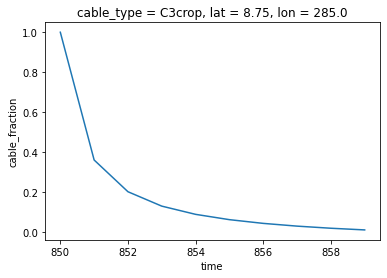

In [12]:
rebuilt_hist_floor[:10,8,79,152].plot()

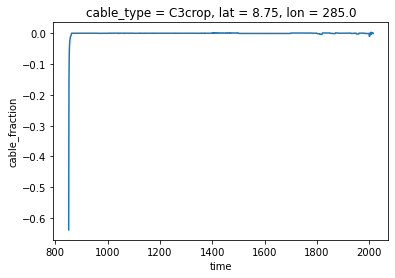

In [17]:
rebuilt_hist_floor[:,8,79,152].diff('time').plot()

In [77]:
sample = cable_hist.fraction[:,:,78:81,151:154]

In [75]:
w = estimate_block(cable[:,:,78:81,151:154].compute(), luh2[:,:,78:81,151:154].compute())

In [78]:
luh_w = xarray.DataArray(
                 w,
                 name='luh2_to_cable_types',
                 coords=[
                     ('luh2_type', luh_hist_da['type']),
                     ('cable_type', cable_hist['vegtype']), 
                     ('lat', sample['latitude']), 
                     ('lon', sample['longitude']), 
                 ])

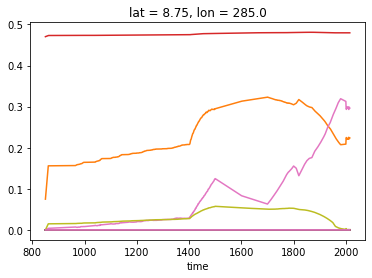

In [79]:
rebuilt_hist_w = (luh_w[:,:,1:2,1:2] * luh_hist_da[:,:,79:80,152:153].rename(type='luh2_type').fillna(0).chunk({'time': 50})).sum('luh2_type').transpose('time', 'cable_type', 'lat', 'lon')
rebuilt_hist_w[:,:,0,0].plot.line(x='time', add_legend=False);

In [80]:
luh_w

<xarray.DataArray 'luh2_to_cable_types' (luh2_type: 13, cable_type: 17, lat: 3, lon: 3)>
array([[[[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.18939126,  0.12580237,  0.18879776],
         [ 0.27157557,  0.1378102 ,  0.14019075],
         [ 0.13221964,  0.        ,  0.08991951]],

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        ...,

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
...
         [ 0.65238875,  0.1063001 , -0.13470705],
         [-0.0582059 ,  0.        , -0.08740707]],

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        ...,

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]]]], dtype=float32)
Coordinates:
  * luh2_type   (luh2_type) <U8 'c3ann' 'c3nfx' 'c3per' ... 'urban' 'constant'
  * cable_type  (cable_type) <U27 'Evergreen Needleleaf Forest' ... 'ice'
  * lat         (lat) float32 7.5 8.75 10.0
  * lon         (lon) float32 283.1 285.0 286.9

In [67]:
rebuilt_hist = (luh_weights[:,:,79:80,152:153] * luh_hist_da[:,:,79:80,152:153].rename(type='luh2_type').fillna(0).chunk({'time': 50})).sum('luh2_type').transpose('time', 'cable_type', 'lat', 'lon')

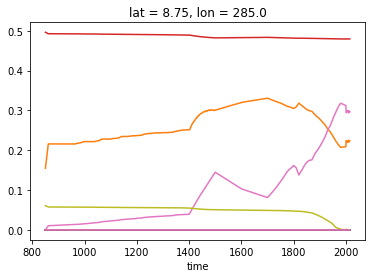

In [62]:
rebuilt_hist[:,:,0,0].plot.line(x='time', add_legend=False);

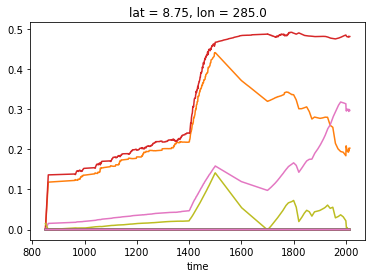

In [68]:
rebuilt_hist[:,:,0,0].plot.line(x='time', add_legend=False);

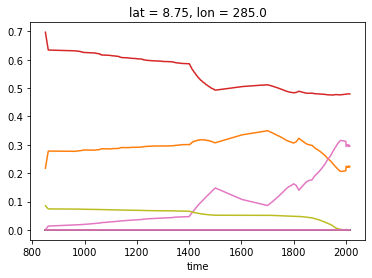

In [61]:
(rebuilt_hist[:,:,0,0] / rebuilt_hist[:,:,0,0].sum('cable_type')).plot.line(x='time', add_legend=False);

In [64]:
data = rebuilt_hist[:,:,79,152].load() #.plot(x='time');

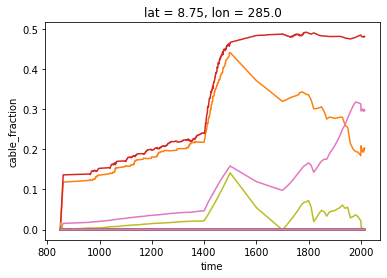

In [65]:
data.plot.line(x='time', add_legend=False);

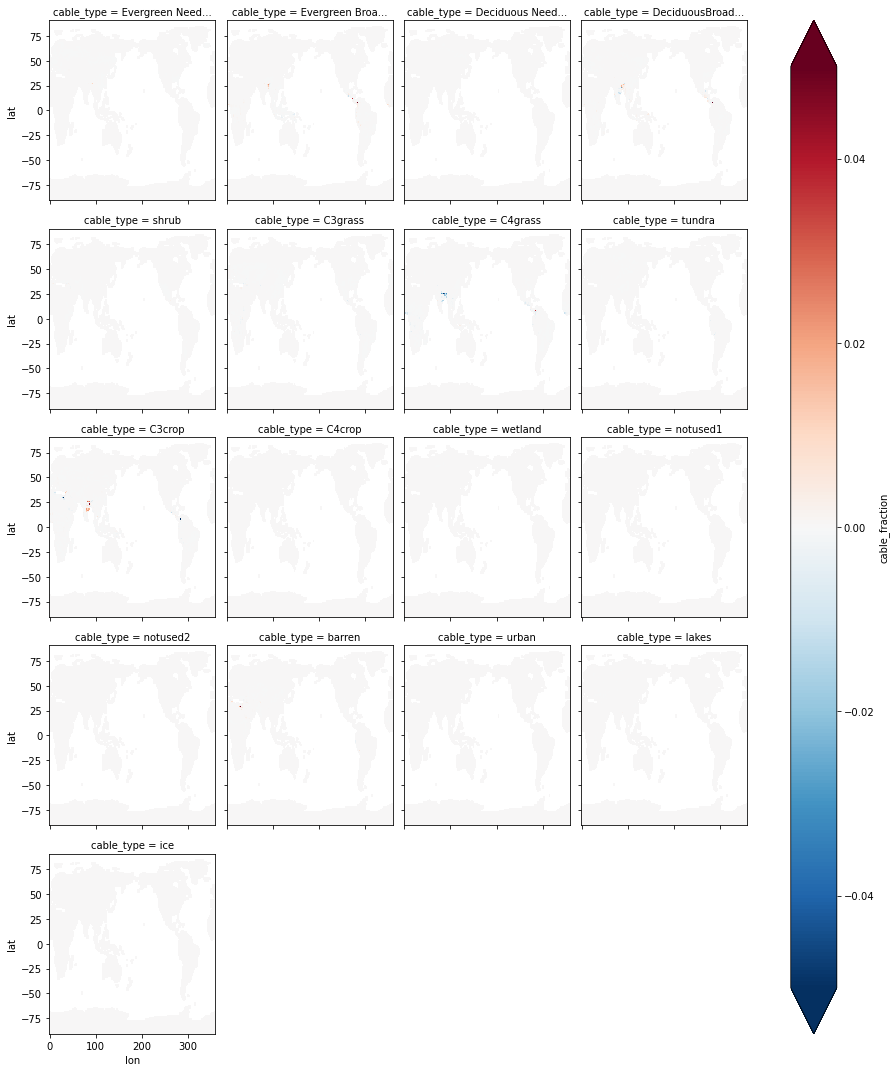

In [16]:
delta.plot(col='cable_type', col_wrap=4, vmax=0.05)

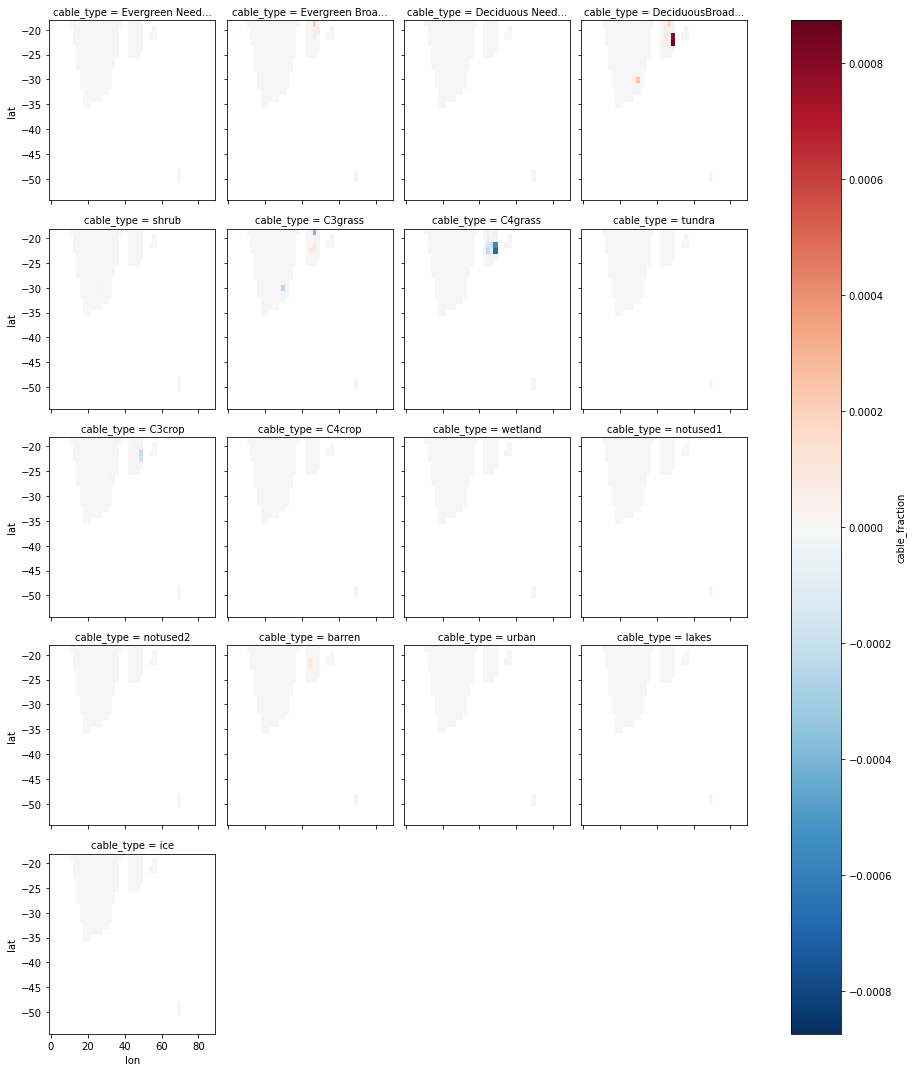

In [12]:
sample = rebuilt_hist_floor[:,:,29:58,0:48]
(sample[1,...] - sample[0,...]).plot(col='cable_type', col_wrap=4)

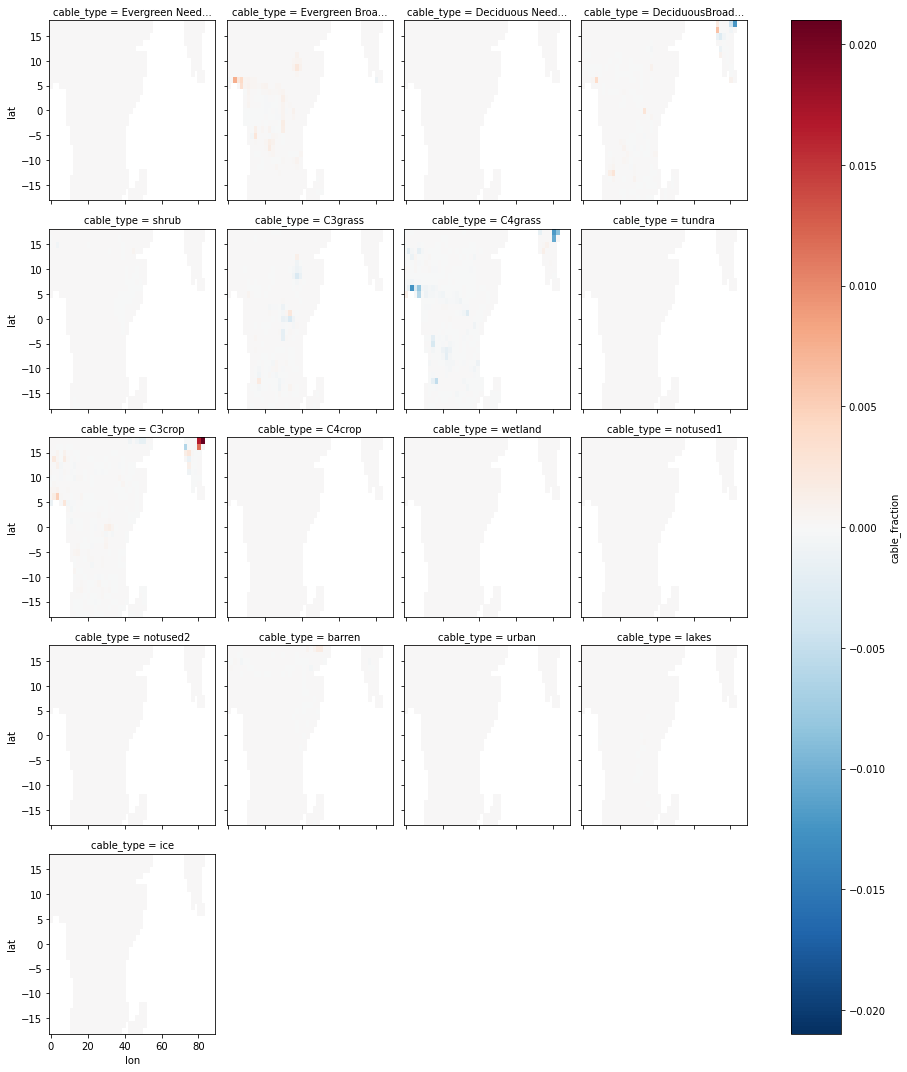

In [13]:
sample = rebuilt_hist_floor[:,:,58:87,0:48]
(sample[1,...] - sample[0,...]).plot(col='cable_type', col_wrap=4)

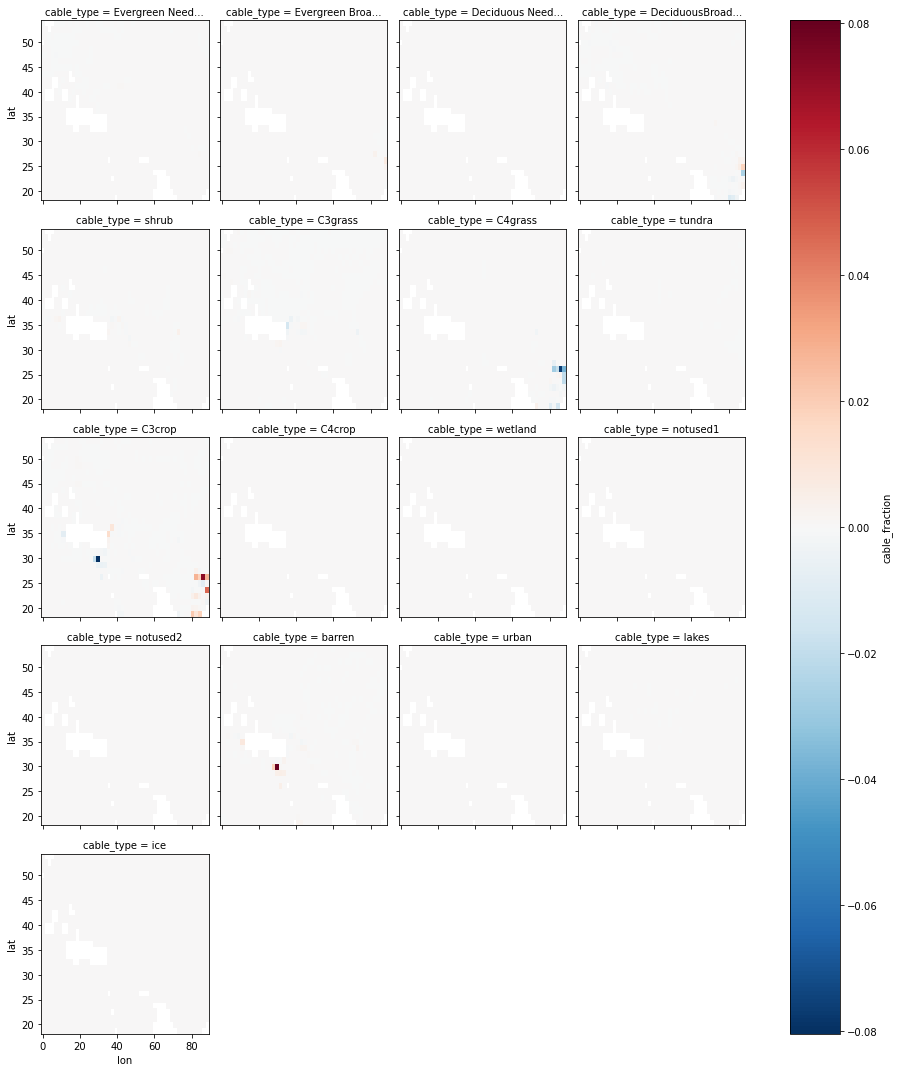

In [14]:
sample = rebuilt_hist_floor[:,:,87:116,0:48]
(sample[1,...] - sample[0,...]).plot(col='cable_type', col_wrap=4)

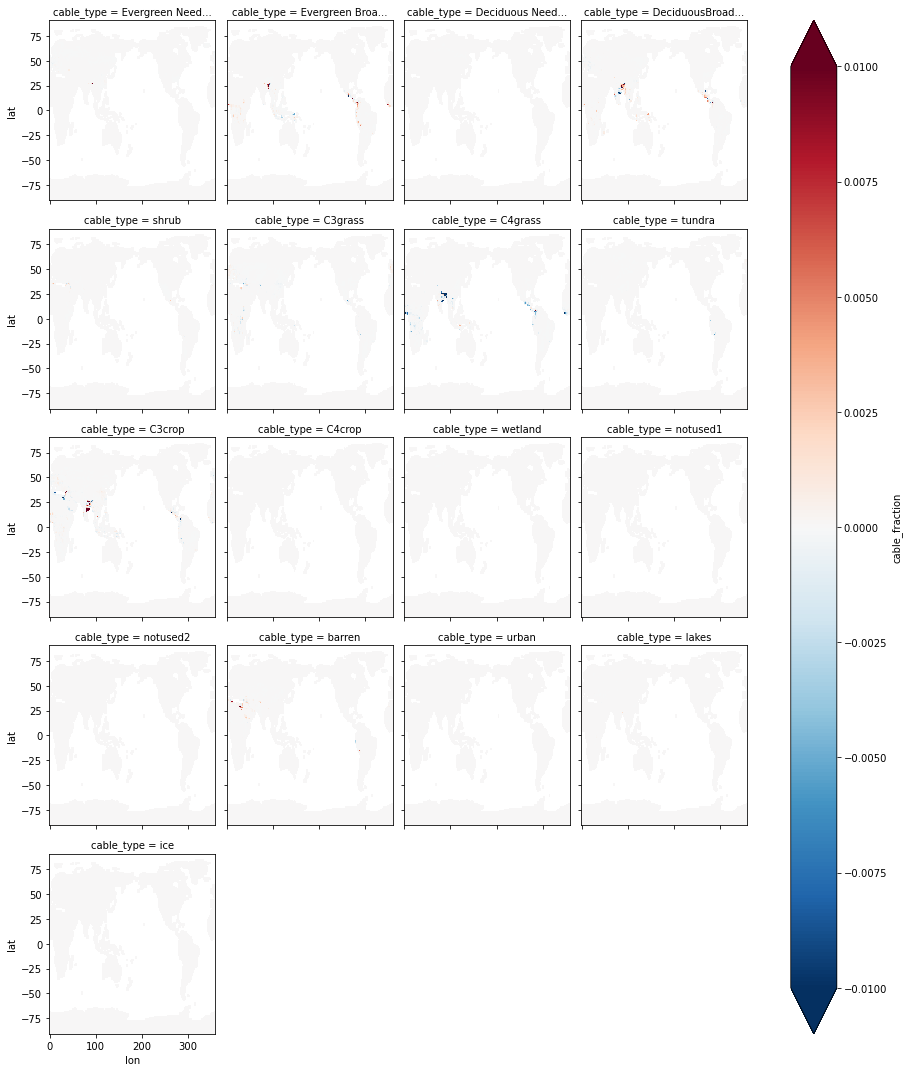

In [19]:
sample = rebuilt_hist_floor
(sample[1,...] - sample[0,...]).plot(col='cable_type', col_wrap=4, vmax=0.01)